# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_**All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.**_

## Requirements

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project._

* Code clarity: make sure the code conforms to:
    * [ ] [PEP 8](https://peps.python.org/pep-0008/) - You might find [this resource](https://realpython.com/python-pep8/) helpful as well as [this](https://github.com/dnanhkhoa/nb_black) or [this](https://jupyterlab-code-formatter.readthedocs.io/en/latest/) tool
    * [ ] [PEP 257](https://peps.python.org/pep-0257/)
    * [ ] Break each task down into logical functions
* The following files are submitted for the project (see the project's GDoc for more details):
    * [ ] `README.md`
    * [ ] `requirements.txt`
    * [ ] `.gitignore`
    * [ ] `schema.sql`
    * [ ] 6 query files (using the `.sql` extension), appropriately named for the purpose of the query
    * [x] Jupyter Notebook containing the project (this file!)
* [x] You can edit this cell and add a `x` inside the `[ ]` like this task to denote a completed task

## Project Setup

In [1]:
# all import statements needed for the project, for example:

import requests
import bs4
import re
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import geopandas as gpd
from skimpy import clean_columns
import sqlalchemy as db
import matplotlib.pyplot as plt
import math
import os
import io

import matplotlib

import seaborn as sns
import folium 
import sqlite3
from sqlite3 import connect

In [2]:
# any general notebook setup, like log formatting

In [3]:
# any constants you might need, for example:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_DATA = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
ny_lat0, ny_lon0 = NEW_YORK_BOX_COORDS[0]
ny_lat1, ny_lon1 = NEW_YORK_BOX_COORDS[1]

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Define a function that calculates the distance between two coordinates in kilometers that **only uses the `math` module** from the standard library.
* [ ] Taxi data:
    * [ ] Use the `re` module, and the packages `requests`, BeautifulSoup (`bs4`), and (optionally) `pandas` to programmatically download the required CSV files & load into memory.
    * You may need to do this one file at a time - download, clean, sample. You can cache the sampling by saving it as a CSV file (and thereby freeing up memory on your computer) before moving onto the next file. 
* [ ] Weather & Uber data:
    * [ ] Download the data manually in the link provided in the project doc.
* [ ] All data:
    * [ ] Load the data using `pandas`
    * [ ] Clean the data, including:
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * (Taxi & Uber data) Remove trips that start and/or end outside the designated [coordinate box](http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047)
    * [ ] (Taxi data) Sample the data so that you have roughly the same amount of data points over the given date range for both Taxi data and Uber data.
* [ ] Weather data:
    * [ ] Split into two `pandas` DataFrames: one for required hourly data, and one for the required daily daya.
    * [ ] You may find that the weather data you need later on does not exist at the frequency needed (daily vs hourly). You may calculate/generate samples from one to populate the other. Just document what you’re doing so we can follow along. 

### Data lookup from taxi_zones.shp

In [4]:
taxi_zone = gpd.read_file(r"taxi_zones.shp")

In [5]:
# Get the center of each polygon
taxi_zone = taxi_zone.to_crs(4326)
taxi_zone["lon"] = taxi_zone.centroid.x
taxi_zone["lat"] = taxi_zone.centroid.y

# make sure that the coodinate is located inside NY bounding box
taxi_zone = taxi_zone[(taxi_zone["lon"] > ny_lon0) & (taxi_zone["lon"] < ny_lon1)]
taxi_zone = taxi_zone[(taxi_zone["lat"] > ny_lon1) & (taxi_zone["lat"] < ny_lat1)]

/tmp/ipykernel_1956/3630155683.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zone["lon"] = taxi_zone.centroid.x
/tmp/ipykernel_1956/3630155683.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zone["lat"] = taxi_zone.centroid.y


In [6]:
#create dataframe to handle location data
df_taxi_zone = taxi_zone[["LocationID"]].copy()

df_taxi_zone["latitude"] = taxi_zone.lat
df_taxi_zone["longitude"] = taxi_zone.lon

df_taxi_zone = df_taxi_zone.dropna()
df_taxi_zone.head(144)

,LocationID,latitude,longitude
0,1,40.691831,-74.174000
1,2,40.616745,-73.831299
2,3,40.864474,-73.847422
3,4,40.723752,-73.976968
4,5,40.552659,-74.188484
...,...,...,...
140,141,40.766948,-73.959635
141,142,40.773633,-73.981532
142,143,40.775965,-73.987646
143,144,40.720889,-73.996919


In [7]:
#Validate of NY bounding box (df_location)
"""
lat_result = []
lon_result = []

for data in range(len(df_location.coordinate)):
    lat, lon = df_location["coordinate"].iloc[data]
    
    lat_result.append(lat)
    lon_result.append(lon)

min_lat = min(lat_result)
max_lat = max(lat_result)
min_lon = min(lon_result)
max_lon = max(lon_result)
"""
# Note: NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
# min_lon, max_lon = (-74.23353354937652, -73.72665537528711)
# min_lat, max_lat = (40.525494581763816, 40.89952906437648)

'\nlat_result = []\nlon_result = []\n\nfor data in range(len(df_location.coordinate)):\n    lat, lon = df_location["coordinate"].iloc[data]\n    \n    lat_result.append(lat)\n    lon_result.append(lon)\n\nmin_lat = min(lat_result)\nmax_lat = max(lat_result)\nmin_lon = min(lon_result)\nmax_lon = max(lon_result)\n'

### Calculating distance
_**TODO:** Write some prose that tells the reader what you're about to do here._

In [8]:
def calculate_distance(from_coord, to_coord):
    
    result = []
    
    for data in range(max(len(from_coord), len(to_coord))):
        lat1, lon1 = from_coord[data]
        lat2, lon2 = to_coord[data]
                      
        #method to convert a degree value into radians
        lon1 = math.radians(lon1)
        lon2 = math.radians(lon2)
        lat1 = math.radians(lat1)
        lat2 = math.radians(lat2)
        
        #Haversine Formula
        diff_lon = lon2 - lon1 
        diff_lat = lat2 - lat1
        
        a = math.sin(diff_lat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(diff_lon / 2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        
        # Radius of earth in kilometers. Use 3956 for miles
        r = 6371
                      
        #calculate the result
        distance = r*c
        result.append(distance)
    
    distance_series = pd.Series(result)
                      
    return distance_series

In [9]:
def add_distance_column_1(dataframe):    
    dataframe["pickup_coordinate"] = pd.Series(zip(dataframe["pickup_latitude"], dataframe["pickup_longitude"]))
    dataframe["dropoff_coordinate"] = pd.Series(zip(dataframe["dropoff_latitude"], dataframe["dropoff_longitude"]))
    dataframe["distance"] = calculate_distance(dataframe["pickup_coordinate"], dataframe["dropoff_coordinate"])
    return dataframe["distance"]

In [10]:
def add_distance_column_2(dataframe):
    #merge main dataframe with the df_location based on LocationID
    dataframe = dataframe.merge(df_taxi_zone, left_on='PULocationID', right_on='LocationID')
    dataframe = dataframe.merge(df_taxi_zone, left_on='DOLocationID', right_on='LocationID')
    dataframe = dataframe.rename(columns={"latitude_x":"pickup_latitude", "longitude_x":"pickup_longitude",
                                         "latitude_y":"dropoff_latitude", "longitude_y":"dropoff_longitude",})
    
    dataframe["pickup_coordinate"] = pd.Series(zip(dataframe["pickup_latitude"], dataframe["pickup_longitude"]))
    dataframe["dropoff_coordinate"] = pd.Series(zip(dataframe["dropoff_latitude"], dataframe["dropoff_longitude"]))
    
    dataframe["distance"] = calculate_distance(dataframe["pickup_coordinate"], dataframe["dropoff_coordinate"])
    dataframe = dataframe.drop(columns=["LocationID_x","LocationID_y","pickup_coordinate","dropoff_coordinate"])
    dataframe = dataframe.dropna()
    
    return dataframe

### Processing Taxi Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [11]:
def find_taxi_csv_urls():
    #Get taxi HTML
    response = requests.get(TAXI_URL)
    html = response.content
    
    #Find taxi parquet links
    soup = bs4.BeautifulSoup(html, 'html.parser')
    result = [a['href'] for a in soup.find_all('a', title="Yellow Taxi Trip Records")]
    return result

In [12]:
def get_and_clean_month_taxi_data(url):
    dataframe = pd.DataFrame(None)
    match = re.search(r"\w+(?P<year>2009|201[012345])-01.parquet", url) #keep in mind that currently we only take 2022-01 data to make the preprocessing more efficient, we can update the REGEX once we wrapped up all the sections
    
    if match is None:
        pass
    else:
        year = match.group("year")
        response = requests.get(url)
        
        with open(match.group(), "wb") as f:
            for chunk in response.iter_content(chunk_size=1024): 
                if chunk:
                    f.write(chunk)
                    
        with open(match.group(), "r") as f:
            if year == "2009":
                dataframe = pd.read_parquet(match.group(), engine='pyarrow')
                dataframe = dataframe.sample(frac=0.01, random_state=1)
                dataframe = dataframe.reset_index(drop=True)
                
                dataframe = dataframe.rename(columns={"Trip_Pickup_DateTime":"tpep_pickup_datetime",
                                                     "Tip_Amt":"tip_amount",
                                                     "Start_Lon":"pickup_longitude",
                                                     "Start_Lat":"pickup_latitude",
                                                     "End_Lon": "dropoff_longitude",
                                                     "End_Lat": "dropoff_latitude"})
                dataframe = dataframe[["tpep_pickup_datetime", "pickup_longitude", "pickup_latitude",
                                      "dropoff_longitude", "dropoff_latitude","tip_amount"]]

                dataframe["distance"] = add_distance_column_1(dataframe)
                dataframe["tpep_pickup_date"] = pd.to_datetime(dataframe["tpep_pickup_datetime"]).dt.date
                dataframe["tpep_pickup_hour"] = pd.to_datetime(dataframe["tpep_pickup_datetime"]).dt.hour
                dataframe["tpep_pickup_day"] = pd.to_datetime(dataframe["tpep_pickup_datetime"]).dt.day_name()
                
                dataframe = dataframe[['tpep_pickup_date','tpep_pickup_day','tpep_pickup_hour',
                                       'tip_amount','distance','pickup_longitude', 
                                       'pickup_latitude','dropoff_longitude', 'dropoff_latitude']]
                dataframe = dataframe.dropna(subset=["distance"])
                
            elif year == "2010":
                dataframe = pd.read_parquet(match.group(), engine='pyarrow')
                dataframe = dataframe.sample(frac=0.01, random_state=1)
                dataframe = dataframe.reset_index(drop=True)
                
                dataframe = dataframe.rename(columns={"pickup_datetime":"tpep_pickup_datetime"})
                dataframe = dataframe[["tpep_pickup_datetime", "pickup_longitude", "pickup_latitude",
                                      "dropoff_longitude", "dropoff_latitude","tip_amount"]]
                
                dataframe["distance"] = add_distance_column_1(dataframe)
                dataframe["tpep_pickup_date"] = pd.to_datetime(dataframe["tpep_pickup_datetime"]).dt.date
                dataframe["tpep_pickup_hour"] = pd.to_datetime(dataframe["tpep_pickup_datetime"]).dt.hour
                dataframe["tpep_pickup_day"] = pd.to_datetime(dataframe["tpep_pickup_datetime"]).dt.day_name()
                
                dataframe = dataframe[['tpep_pickup_date','tpep_pickup_day','tpep_pickup_hour',
                                       'tip_amount','distance','pickup_longitude', 
                                       'pickup_latitude','dropoff_longitude', 'dropoff_latitude']]
                dataframe = dataframe.dropna(subset=["distance"])
                
            else:    
                dataframe = pd.read_parquet(match.group(), engine='pyarrow')
                dataframe = dataframe.sample(frac=0.01, random_state=1)
                dataframe = dataframe.reset_index(drop=True)
                dataframe = dataframe[['tpep_pickup_datetime','PULocationID', 'DOLocationID','tip_amount']]

                dataframe = add_distance_column_2(dataframe)
                dataframe["tpep_pickup_date"] = pd.to_datetime(dataframe["tpep_pickup_datetime"]).dt.date
                dataframe["tpep_pickup_hour"] = pd.to_datetime(dataframe["tpep_pickup_datetime"]).dt.hour
                dataframe["tpep_pickup_day"] = pd.to_datetime(dataframe["tpep_pickup_datetime"]).dt.day_name()

                dataframe = dataframe[['tpep_pickup_date','tpep_pickup_day','tpep_pickup_hour',
                                       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
                                       'dropoff_latitude','tip_amount','distance']]
                dataframe = dataframe.dropna(subset=["distance"])
                            
    return dataframe

In [13]:
def get_and_clean_taxi_data():
    all_taxi_dataframes = []
    
    all_csv_urls = find_taxi_csv_urls()
    for csv_url in all_csv_urls:
        # maybe: first try to see if you've downloaded this exact
        # file already and saved it before trying again
        dataframe = get_and_clean_month_taxi_data(csv_url)
        
        all_taxi_dataframes.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    
    return taxi_data

### Processing Uber Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [14]:
def load_and_clean_uber_data(csv_file):
    df_uber = pd.read_csv(csv_file)
    
    #renaming old df without creating a copy 
    df_uber.rename(columns={'key': 'date_time', 'Unnamed: 0': 'location_id'}, inplace=True)
    
    #constructing new columns as a function input
    df_uber["pickup_coordinate"] = list(zip(df_uber.pickup_latitude, df_uber.pickup_longitude))
    df_uber["dropoff_coordinate"] = list(zip(df_uber.dropoff_latitude, df_uber.dropoff_longitude))
    
    #calculate distance
    df_uber["distance"] = calculate_distance(df_uber["pickup_coordinate"], df_uber["dropoff_coordinate"])
    
    #make sure that the coordinate is located inside the NY bounding box
    df_uber = df_uber[(df_uber["pickup_longitude"] > ny_lon0) & (df_uber["pickup_longitude"] < ny_lon1)]
    df_uber = df_uber[(df_uber["dropoff_longitude"] > ny_lon0) & (df_uber["dropoff_longitude"] < ny_lon1)]
    df_uber = df_uber[(df_uber["pickup_latitude"] > ny_lat0) & (df_uber["pickup_latitude"] < ny_lat1)]
    df_uber = df_uber[(df_uber["dropoff_latitude"] > ny_lat0) & (df_uber["dropoff_latitude"] < ny_lat1)]
    
    #handle the datetime format
    df_uber["order_date"] = pd.to_datetime(df_uber["date_time"]).dt.date
    df_uber["order_time"] = pd.to_datetime(df_uber["date_time"]).dt.hour
    df_uber["order_day"] = pd.to_datetime(df_uber["date_time"]).dt.day_name()
    
    df_uber["pickup_date"] = pd.to_datetime(df_uber["pickup_datetime"]).dt.date
    df_uber["pickup_time"] = pd.to_datetime(df_uber["pickup_datetime"]).dt.hour
    df_uber["pickup_day"] = pd.to_datetime(df_uber["pickup_datetime"]).dt.day_name()
    
    df_uber = df_uber.drop(columns=["date_time", "pickup_datetime"])
    
    return df_uber

In [15]:
def get_uber_data():
    uber_dataframe = load_and_clean_uber_data(UBER_DATA)
    uber_dataframe = uber_dataframe.drop(columns=["pickup_coordinate","dropoff_coordinate",
                                                  "pickup_longitude", "pickup_latitude", 
                                                  "dropoff_longitude", "dropoff_latitude"])
    
    return uber_dataframe

### Processing Weather Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [16]:
def clean_month_weather_data_hourly(csv_file):
    df_weather = pd.read_csv(csv_file, low_memory = False)
    weather_columns = df_weather.columns.tolist()
    result = ['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'REPORT_TYPE', 'SOURCE']
    
    for column in weather_columns:
        match = re.search(r"Hourly", column)
        if match is None:
            pass
        else:
            result.append(column)
    
    df_weather_hourly = df_weather[result]
    
    return df_weather_hourly

In [17]:
def clean_month_weather_data_daily(csv_file):
    df_weather = pd.read_csv(csv_file, low_memory = False)
    weather_columns = df_weather.columns.tolist()
    result = ['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'REPORT_TYPE', 'SOURCE']
    
    for column in weather_columns:
        match = re.search(r"Daily", column)
        if match is None:
            pass
        else:
            result.append(column)
    
    df_weather_daily = df_weather[result]
    
    return df_weather_daily

In [18]:
def load_and_clean_weather_data():
    hourly_dataframes = []
    daily_dataframes = []
    
    # add some way to find all weather CSV files
    weather_csv_files = []
    list_dir = os.listdir() #list all file within a directory and store in an array

    for file in list_dir:
        match = re.search(r"(2009|201[012345])_weather.csv", file)
        if match is None:
            pass
        else:
            weather_csv_files.append(match.group())
    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    #handle datetime format - hourly data
    hourly_data["ORDER_DATE"] = pd.to_datetime(hourly_data["DATE"]).dt.date
    hourly_data["ORDER_TIME"] = pd.to_datetime(hourly_data["DATE"]).dt.hour
    hourly_data["ORDER_DAY"] = pd.to_datetime(hourly_data["DATE"]).dt.day_name()
    hourly_data = hourly_data.drop(columns=["DATE"])
    
    #handle datetime format - daily data
    daily_data["ORDER_DATE"] = pd.to_datetime(daily_data["DATE"]).dt.date
    daily_data["ORDER_TIME"] = pd.to_datetime(daily_data["DATE"]).dt.hour
    daily_data["ORDER_DAY"] = pd.to_datetime(daily_data["DATE"]).dt.day_name()
    daily_data = daily_data.drop(columns=["DATE"])
    
    return hourly_data, daily_data

### Process All Data

_This is where you can actually execute all the required functions._

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [19]:
taxi_data = get_and_clean_taxi_data()
uber_data = get_uber_data()
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

In [117]:
uber_data.count()

location_id        195472
fare_amount        195472
passenger_count    195472
distance           195472
order_date         195472
order_time         195472
order_day          195472
pickup_date        195472
pickup_time        195472
pickup_day         195472
dtype: int64

In [118]:
taxi_data.count()

tpep_pickup_date     951842
tpep_pickup_day      951842
tpep_pickup_hour     951842
pickup_longitude     951842
pickup_latitude      951842
dropoff_longitude    951842
dropoff_latitude     951842
tip_amount           951842
distance             951842
dtype: int64

In [21]:
taxi_data['tpep_pickup_date'].unique()

array([datetime.date(2015, 1, 12), datetime.date(2015, 1, 28),
       datetime.date(2015, 1, 27), datetime.date(2015, 1, 24),
       datetime.date(2015, 1, 17), datetime.date(2015, 1, 6),
       datetime.date(2015, 1, 8), datetime.date(2015, 1, 16),
       datetime.date(2015, 1, 31), datetime.date(2015, 1, 3),
       datetime.date(2015, 1, 22), datetime.date(2015, 1, 21),
       datetime.date(2015, 1, 25), datetime.date(2015, 1, 10),
       datetime.date(2015, 1, 5), datetime.date(2015, 1, 18),
       datetime.date(2015, 1, 23), datetime.date(2015, 1, 14),
       datetime.date(2015, 1, 15), datetime.date(2015, 1, 29),
       datetime.date(2015, 1, 30), datetime.date(2015, 1, 4),
       datetime.date(2015, 1, 20), datetime.date(2015, 1, 11),
       datetime.date(2015, 1, 19), datetime.date(2015, 1, 1),
       datetime.date(2015, 1, 2), datetime.date(2015, 1, 13),
       datetime.date(2015, 1, 26), datetime.date(2015, 1, 9),
       datetime.date(2015, 1, 7), datetime.date(2014, 1, 3),
  


## Part 2: Storing Cleaned Data

_Write some prose that tells the reader what you're about to do here._

In [22]:
engine = db.create_engine(DATABASE_URL)
engine

Engine(sqlite:///project.db)

In [23]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather
(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    STATION INTEGER,
    LATITUDE REAL,
    LONGITUDE REAL,
    ELEVATION REAL,
    NAME TEXT,
    REPORT_TYPE TEXT,
    SOURCE TEXT,
    HourlyAltimeterSetting REAL,
    HourlyDewPointTemperature REAL,
    HourlyDryBulbTemperature REAL,
    HourlyPrecipitation REAL,
    HourlyPresentWeatherType REAL,
    HourlyPressureChange REAL,
    HourlyPressureTendency REAL,
    HourlyRelativeHumidity REAL,
    HourlySkyConditions REAL,
    HourlySeaLevelPressure REAL,
    HourlyStationPressure REAL,
    HourlyVisibility REAL,
    HourlyWetBulbTemperature REAL,
    HourlyWindDirection REAL,
    HourlyWindGustSpeed REAL,
    HourlyWindSpeed REAL,
    ORDER_DATE DATE,
    ORDER_TIME INTEGER,
    ORDER_DAY STRING
    )
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather
(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    STATION INTEGER,
    LATITUDE REAL,
    LONGITUDE REAL,
    ELEVATION REAL,
    NAME TEXT,
    REPORT_TYPE TEXT,
    SOURCE TEXT,
    DailyAverageDewPointTemperature REAL,
    DailyAverageDryBulbTemperature REAL,
    DailyAverageRelativeHumidity REAL,
    DailyAverageSeaLevelPressure REAL, 
    DailyAverageStationPressure REAL,  
    DailyAverageWetBulbTemperature REAL,
    DailyAverageWindSpeed REAL,        
    DailyCoolingDegreeDays REAL,       
    DailyDepartureFromNormalAverageTemperature REAL,
    DailyHeatingDegreeDays REAL,        
    DailyMaximumDryBulbTemperature REAL,
    DailyMinimumDryBulbTemperature REAL,
    DailyPeakWindDirection REAL,        
    DailyPeakWindSpeed REAL,            
    DailyPrecipitation REAL,            
    DailySnowDepth REAL,                
    DailySnowfall REAL,                 
    DailySustainedWindDirection REAL,   
    DailySustainedWindSpeed REAL,       
    DailyWeather TEXT,
    ORDER_DATE DATE,
    ORDER_TIME INTEGER,
    ORDER_DAY STRING
    )
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips
(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    tpep_pickup_date DATE,
    tpep_pickup_day STRING,
    tpep_pickup_hour INTEGER,
    pickup_longitude REAL,
    pickup_latitude REAL,
    dropoff_longitude REAL,
    dropoff_latitude REAL,
    tip_amount REAL,
    distance REAL
)
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips
(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    location_id BIGINT,
    fare_amount REAL,
    pickup_longitude REAL,
    pickup_latitude REAL,
    dropoff_longitude REAL,
    dropoff_latitude REAL,
    pickup_datetime TEXT,
    passenger_count INTEGER,
    distance REAL,
    order_date DATE,
    order_time INTEGER,
    order_day STRING,
    pickup_date DATE,
    pickup_time INTEGER,
    pickup_day STRING
)
"""

In [24]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [25]:
# create the tables with the schema files
with engine.connect() as connection:
    connection.execute(UBER_TRIPS_SCHEMA)
    connection.close()

### Add Data to Database

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [26]:
def write_dataframes_to_table(table_to_df_dict):
    for key, value in table_to_df_dict.items():
        value.to_sql(key, engine, index=True, index_label="id", if_exists='append')

In [27]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data
}

In [28]:
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* [ ] For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* [ ] What is the 95% percentile of distance traveled for all hired trips during July 2013?
* [ ] What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* [ ] Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* [ ] During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [29]:
def write_query_to_file(query, outfile):
    with open(outfile, "w") as f:
        f.write(query)

### Query N

_**TODO:** Write some prose that tells the reader what you're about to do here._

_Repeat for each query_

In [30]:
#DONT FORGET TO ADJUST THE pickup date to BETWEEN 2009-01-01 AND 2015-06-30
QUERY_1 = """
SELECT tpep_pickup_hour as order_hour,
    COUNT(id) as num_order    
FROM taxi_trips
WHERE tpep_pickup_date BETWEEN "2009-01-01" AND "2015-06-30" 
GROUP BY order_hour
ORDER BY num_order DESC
"""

In [31]:
#DONT FORGET TO ADJUST THE pickup date to BETWEEN 2009-01-01 AND 2015-06-30
QUERY_2 = """
SELECT order_day,
    COUNT(id) as num_order    
FROM uber_trips
WHERE order_date BETWEEN "2009-01-01" AND "2015-06-30" 
GROUP BY order_day
ORDER BY num_order DESC
"""

In [32]:
#DONT FORGET TO ADJUST THE pickup date to in July 2013
#Still confuse wheteher to use NTILE(95) or NTILE(5)
QUERY_3 = """
WITH data AS (SELECT distance, NTILE(95) OVER (ORDER BY distance) AS percentile
           FROM taxi_trips
           WHERE tpep_pickup_date BETWEEN "2014-01-01" AND "2014-01-31")
SELECT MAX(distance) as distance
FROM data
GROUP BY percentile;
"""

In [33]:
#DONT FORGET TO ADJUST THE pickup date to BETWEEN 2009-01-01 AND 2009-12-31
QUERY_4 = """
SELECT tpep_pickup_date as order_date,
    COUNT(id) as num_order
FROM taxi_trips
WHERE order_date BETWEEN "2014-01-01" AND "2014-01-31"
GROUP BY order_date
ORDER BY num_order DESC
LIMIT 10"""

In [34]:
#DONT FORGET TO ADJUST THE pickup date to BETWEEN 2014-01-01 to 2014-12-31
QUERY_5 = """
WITH taxi_trip AS (
    SELECT tpep_pickup_date as order_date,
        COUNT(id) as num_order    
    FROM taxi_trips
    WHERE tpep_pickup_date BETWEEN "2014-01-01" AND "2014-01-31"
    GROUP BY order_date
    ORDER BY num_order DESC
    ),
    daily_observation_data AS (
    SELECT ORDER_DATE as order_date,
        AVG(DailyAverageWindSpeed) as avg_wind_speed
    FROM daily_weather
    WHERE order_date BETWEEN "2014-01-01" AND "2014-01-31"
    GROUP BY order_date
    ORDER BY avg_wind_speed DESC
    LIMIT 10
    )
SELECT daily_observation_data.order_date,
    daily_observation_data.avg_wind_speed,
    taxi_trip.num_order
FROM daily_observation_data
LEFT JOIN taxi_trip ON daily_observation_data.order_date = taxi_trip.order_date
"""

In [35]:
#DONT FORGET TO CHANGE THE PERIOD TO BETWEEN "2012-10-22" AND "2012-11-06"
#NEED TO CLARIFY WHETHER TO USE AVERAGE OR MAX IN AGGREGATING THE PRECIPITATION AND WIND SPEED DATA
QUERY_6 = """
WITH weather_data AS (
    SELECT ORDER_TIME AS order_hour,
        ROUND(AVG(HourlyWindSpeed),2) wind_speed,
        ROUND(AVG(HourlyPrecipitation),2) precipitation
    FROM hourly_weather
    WHERE ORDER_DATE BETWEEN "2014-01-01" AND "2014-01-31"
    GROUP BY order_hour
), trip_data AS (
    SELECT tpep_pickup_hour as order_hour,
        COUNT(id) as num_order    
    FROM taxi_trips
    WHERE tpep_pickup_date BETWEEN "2014-01-01" AND "2014-01-31"
    GROUP BY order_hour
    ORDER BY num_order DESC
)
SELECT weather_data.order_hour,
    wind_speed,
    precipitation,
    num_order
FROM weather_data
LEFT JOIN trip_data ON weather_data.order_hour = trip_data.order_hour
"""

In [36]:
engine.execute(QUERY_6).fetchall()

[(0, 6.74, 0.02, 5161),
 (1, 6.38, 0.01, 3813),
 (2, 6.93, 0.01, 2853),
 (3, 6.36, 0.0, 2136),
 (4, 6.91, 0.0, 1519),
 (5, 8.0, 0.01, 1351),
 (6, 7.18, 0.0, 2799),
 (7, 7.13, 0.01, 4942),
 (8, 6.8, 0.02, 6147),
 (9, 6.09, 0.02, 6449),
 (10, 5.2, 0.06, 6137),
 (11, 5.88, 0.06, 6254),
 (12, 6.44, 0.0, 6649),
 (13, 6.07, 0.0, 6620),
 (14, 6.67, 0.01, 6889),
 (15, 6.82, 0.0, 6747),
 (16, 5.96, 0.01, 5718),
 (17, 6.65, 0.02, 6999),
 (18, 6.16, 0.01, 8300),
 (19, 7.48, 0.01, 8597),
 (20, 6.81, 0.01, 7950),
 (21, 5.84, 0.01, 7693),
 (22, 7.0, 0.01, 7354),
 (23, 5.96, 0.01, 6427)]

In [37]:
#engine.execute(QUERY_1).fetchall()

In [38]:
write_query_to_file(QUERY_1, "query_1.sql")

In [39]:
"""write_query_to_file(QUERY_1, "popular_hour_yellow_taxi.sql")
write_query_to_file(QUERY_2, "popular_week_uber.sql")
write_query_to_file(QUERY_3, "95thpercentile_alltrips_Jul2013.sql")
write_query_to_file(QUERY_4, "highest_hired_rides_2009.sql")
write_query_to_file(QUERY_5, "widniestday_hiredtrips_2014.sql")
write_query_to_file(QUERY_6, "hurricane_sandy_week_trips.sql")"""

'write_query_to_file(QUERY_1, "popular_hour_yellow_taxi.sql")\nwrite_query_to_file(QUERY_2, "popular_week_uber.sql")\nwrite_query_to_file(QUERY_3, "95thpercentile_alltrips_Jul2013.sql")\nwrite_query_to_file(QUERY_4, "highest_hired_rides_2009.sql")\nwrite_query_to_file(QUERY_5, "widniestday_hiredtrips_2014.sql")\nwrite_query_to_file(QUERY_6, "hurricane_sandy_week_trips.sql")'

## Part 4: Visualizing the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Create an appropriate visualization for the first query/question in part 3
* [ ] Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
* [ ] Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
* [ ] Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
* [ ] Create a scatter plot that compares tip amount versus distance.
* [ ] Create another scatter plot that compares tip amount versus precipitation amount.

_Be sure these cells are executed so that the visualizations are rendered when the notebook is submitted._

### Visualization N

_**TODO:** Write some prose that tells the reader what you're about to do here._

_Repeat for each visualization._

_The example below makes use of the `matplotlib` library. There are other libraries, including `pandas` built-in plotting library, kepler for geospatial data representation, `seaborn`, and others._

In [40]:
# use a more descriptive name for your function
def plot_visual_n(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    values = "..."  # use the dataframe to pull out values needed to plot
    
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    axes.plot(values, "...")
    # there are other methods to use to label your axes, to style 
    # and set up axes labels, etc
    axes.set_title("Some Descriptive Title")
    
    plt.show()

In [41]:
def get_data_for_visual_n():
    # Query SQL database for the data needed.
    # You can put the data queried into a pandas dataframe, if you wish
    raise NotImplemented()

In [42]:
some_dataframe = get_data_for_visual_n()
plot_visual_n(some_dataframe)

TypeError: 'NotImplementedType' object is not callable

#### Visualization for Query 1 

Questions: do we use write_dataframe_to_table function above? 

QUERY_1 = """
SELECT tpep_pickup_hour as order_hour,
    COUNT(id) as num_order    
FROM taxi_trips
WHERE tpep_pickup_date BETWEEN "2014-01-01" AND "2014-01-31" 
GROUP BY order_hour
ORDER BY num_order DESC
"""

In [271]:
# "THIS IS WORKING"
def plot_visual_query_1(dataframe):
    dataframe_query_1 = dataframe
    figure, axes = plt.subplots(figsize=(20, 10))
    tick_labels = list(range(1,25))
    axes.bar(dataframe_query_1["order_hour"], dataframe_query_1["num_order"], 
             tick_label=tick_labels, color = 'lightblue')
    axes.set_title("Orders each Hour of Day from 2009-01-01 to 2015-06-30")
    axes.set_ylabel("Total trip orders")
    
    axes.set_xlabel("Hour of the day")
       
    plt.show()


In [272]:
# "THIS IS WORKING"
def get_data_for_visual_1():
    conn = sqlite3.connect("project.db")
    dataframe_query_1 = pd.read_sql(QUERY_1, conn)
    dataframe_query_1 = dataframe_query_1.sort_values('order_hour')
    return dataframe_query_1

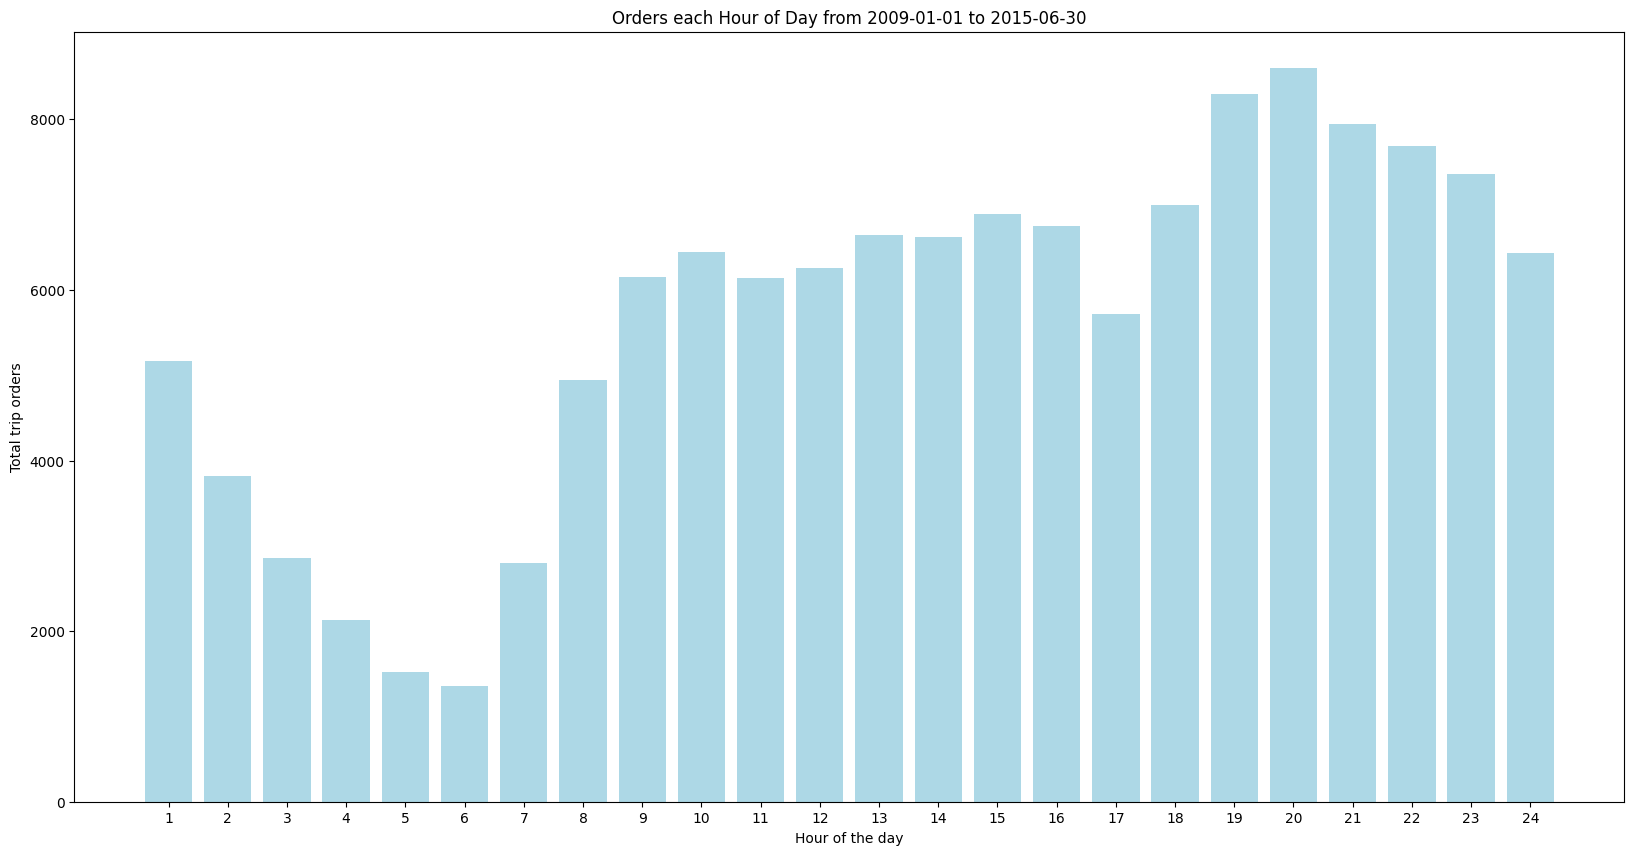

In [273]:
# "THIS IS WORKING"
dataframe_query_1 = get_data_for_visual_1()
plot_visual_query_1(dataframe_query_1)

#### Visualization for Question 2

Using seaborn count plot and regplot for confidence interval 
https://seaborn.pydata.org/generated/seaborn.countplot.html
https://seaborn.pydata.org/generated/seaborn.lineplot.html 

*Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month) for both taxis and Ubers combined. Include the 90% confidence interval around the mean in the visualization



https://stackoverflow.com/questions/59747313/how-can-i-plot-a-confidence-interval-in-python

https://blog.finxter.com/how-to-plot-the-confidence-interval-in-python/


https://matplotlib.org/stable/gallery/units/bar_unit_demo.html#sphx-glr-gallery-units-bar-unit-demo-py

In [55]:
###Test for yellow taxis 

dataframe_yellow_taxis = pd.read_sql_table('taxi_trips', engine)
dataframe_yellow_taxis["month"] = dataframe_yellow_taxis["tpep_pickup_date"].apply(lambda x:x.month)

grouped = dataframe_yellow_taxis[['distance','month']].groupby('month')
new_dataframe_yellow_taxis = grouped.mean()
new_dataframe_yellow_taxis

,distance
month,
1,4.126206


In [ ]:
###Test for uber trips

"""dataframe_uber_trips = pd.read_sql_table('uber_trips', engine)
dataframe_uber_trips["month"] = dataframe_uber_trips["order_date"].apply(lambda x:x.month)
#df2
grouped = dataframe_uber_trips[['distance','month']].groupby('month')
new_dataframe_uber_trips = grouped.mean()
new_dataframe_uber_trips"""

In [ ]:
"""###Might not need this 
df_q2 = new_dataframe_yellow_taxis.merge(new_dataframe_uber_trips, how = "outer", on='month')
df_q2"""

In [ ]:
labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

figure, axes = plt.subplots(figsize=(20, 10))
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
N=12
ind = np.arange(N)  # the x locations for the groups
width = 0.35         # the width of the bars

axes.bar(x - width/2, np.array(new_dataframe_yellow_taxis["distance"]), width, label='yellow taxi')


axes.bar(x + width/2, np.array(new_dataframe_uber_trips["distance"]), width, label='uber trips')

plt.show()


In [216]:
# "THIS IS WORKING"

"""
A lineplot was used instead of a bargraph since it is easier to understand average distance travelled each month by both uber
yellow taxis with a confidence interval 
"""
def plot_visual_2(dataframe1, dataframe2):
    dataframe1 = new_dataframe_yellow_taxis
    dataframe2 = new_dataframe_uber_trips
    
    labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    figure, axes = plt.subplots(figsize=(20, 10))
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars
    N=12
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35         # the width of the bars

    axes.bar(x - width/2, np.array(new_dataframe_yellow_taxis["distance"]), width,tick_label=labels, label='yellow taxi')


    axes.bar(x + width/2, np.array(new_dataframe_uber_trips["distance"]), width, label='uber trips')

    plt.show()


In [217]:
# "THIS IS WORKING"
def get_data_for_visual_2():
    dataframe_yellow_taxis = pd.read_sql_table('taxi_trips', engine)
    dataframe_yellow_taxis["month"] = dataframe_yellow_taxis["tpep_pickup_date"].apply(lambda x:x.month)
    
    grouped = dataframe_yellow_taxis[['distance','month']].groupby('month')
    new_dataframe_yellow_taxis = grouped.mean()#.sort_values('float_time',ascending=False)
    
    
    dataframe_uber_trips = pd.read_sql_table('uber_trips', engine)
    dataframe_uber_trips["month"] = dataframe_uber_trips["order_date"].apply(lambda x:x.month)
    
    grouped = dataframe_uber_trips[['distance','month']].groupby('month')
    new_dataframe_uber_trips = grouped.mean()#.sort_values('float_time',ascending=False)
    
    
    return new_dataframe_yellow_taxis, new_dataframe_uber_trips

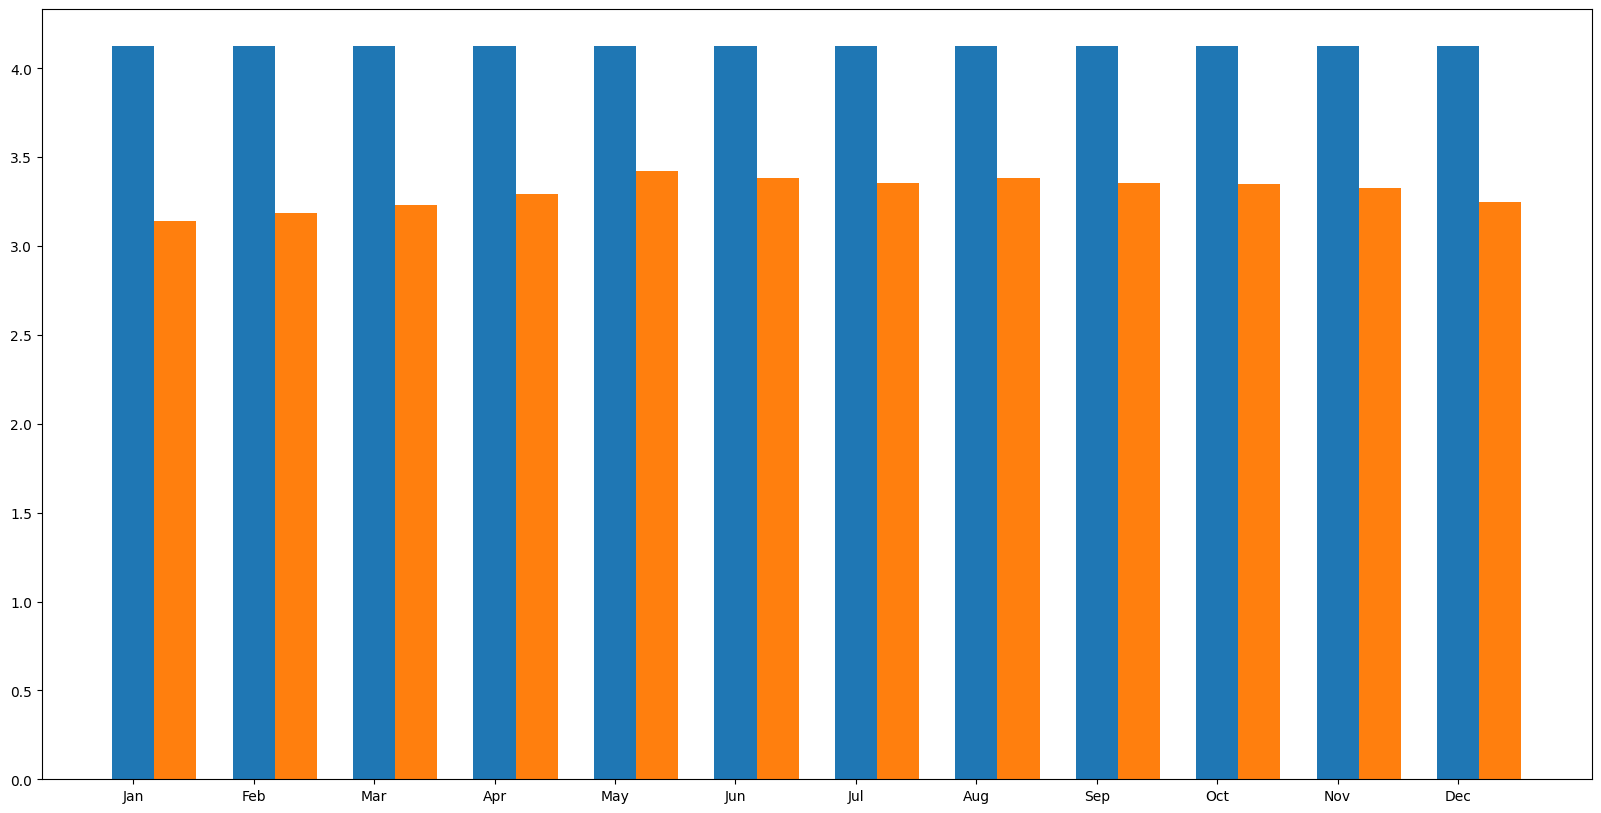

In [218]:
# "THIS IS WORKING"
new_dataframe_yellow_taxis, new_dataframe_uber_trips = get_data_for_visual_2()
plot_visual_2(new_dataframe_yellow_taxis, new_dataframe_uber_trips)

In [214]:
dataframe_uber_trips = pd.read_sql_table('uber_trips', engine)
dataframe_uber_trips["month"] = dataframe_uber_trips["order_date"].apply(lambda x:x.month)
#df2
grouped = dataframe_uber_trips[['distance','month']].groupby('month')
new_dataframe_uber_trips = grouped.mean()
new_dataframe_uber_trips


,distance
month,
1,3.139044
2,3.187771
3,3.228518
4,3.295871
5,3.423026
6,3.383365
7,3.354625
8,3.382306
9,3.354267


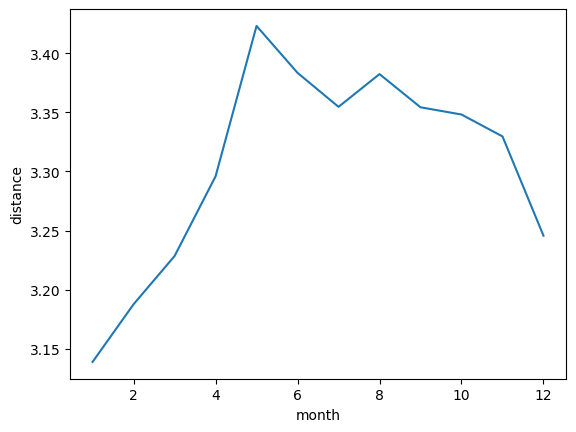

In [215]:
sns.lineplot(x = 'month', y ='distance', data = new_dataframe_uber_trips  )
plt.show()

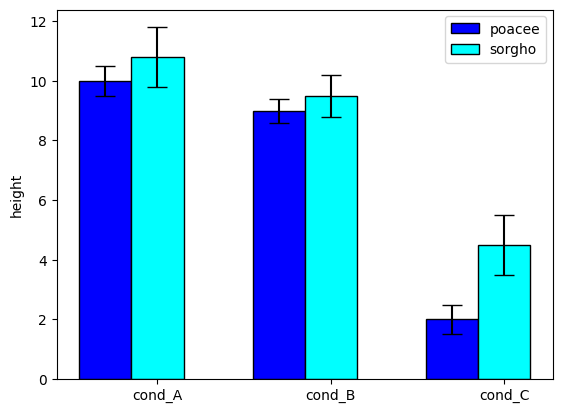

In [270]:
# libraries
 
# width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars
bars1 = [10, 9, 2]
 
# Choose the height of the cyan bars
bars2 = [10.8, 9.5, 4.5]
 
# Choose the height of the error bars (bars1)
yer1 = [0.5, 0.4, 0.5]
 
# Choose the height of the error bars (bars2)
yer2 = [1, 0.7, 1]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='poacee')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='sorgho')
 
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ['cond_A', 'cond_B', 'cond_C'])
plt.ylabel('height')
plt.legend()
 
# Show graphic
plt.show()

In [ ]:
# width of the bars
barWidth = 0.35
 
# Choose the height of the blue bars
bars1 = [10, 9, 2]
 
# Choose the height of the cyan bars
bars2 = [10.8, 9.5, 4.5]
 
# Choose the height of the error bars (bars1)
yer1 = [0.5, 0.4, 0.5]
 
# Choose the height of the error bars (bars2)
yer2 = [1, 0.7, 1]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='poacee')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='sorgho')
 
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ['cond_A', 'cond_B', 'cond_C'])
plt.ylabel('height')
plt.legend()
 
# Show graphic
plt.show()

# Trying seaborn for ci

In [274]:
dataframe_yellow_taxis = pd.read_sql_table('taxi_trips', engine)
dataframe_yellow_taxis["month"] = dataframe_yellow_taxis["tpep_pickup_date"].apply(lambda x:x.month)

grouped = dataframe_yellow_taxis[['distance','month']].groupby('month')
new_dataframe_yellow_taxis = grouped.mean()
new_dataframe_yellow_taxis


,distance
month,
1,4.126206


In [275]:
dataframe_uber_trips = pd.read_sql_table('uber_trips', engine)
dataframe_uber_trips["month"] = dataframe_uber_trips["order_date"].apply(lambda x:x.month)
#df2
grouped = dataframe_uber_trips[['distance','month']].groupby('month')
new_dataframe_uber_trips = grouped.mean()
new_dataframe_uber_trips

,distance
month,
1,3.139044
2,3.187771
3,3.228518
4,3.295871
5,3.423026
6,3.383365
7,3.354625
8,3.382306
9,3.354267


In [285]:
df_q2 = new_dataframe_yellow_taxis.merge(new_dataframe_uber_trips, how = "outer", on='month')


df_q2 = df_q2.rename(columns={'distance_x': 'Yellow Taxis Distance', 'distance_y': 'Uber Trips Distance'})
df_q2

,Yellow Taxis Distance,Uber Trips Distance
month,,
1,4.126206,3.139044
2,NaN,3.187771
3,NaN,3.228518
4,NaN,3.295871
5,NaN,3.423026
6,NaN,3.383365
7,NaN,3.354625
8,NaN,3.382306
9,NaN,3.354267


In [287]:

sns.barplot(data=df_q2, x=df_q2.index, y= 'month', hue = 'distance')

ValueError: Could not interpret input 'month'

#### Visualization for Question 3

Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport. 

In [60]:
lat_long_box_1 = ((40.766762,-73.889279),(40.786455,-73.855033)) #LGA box coordinates
lat_long_box_2 = ((40.624832,-73.820744),(40.666382,-73.748131)) #JFK box coordinates
lat_long_box_3 = ((40.670809,-74.193163),(40.707775,-74.153509)) #EWR box coordinates

dataframe_yellow_taxis = pd.read_sql_table('taxi_trips', engine)
#grouped = dataframe_yellow_taxis[['droppoff_latitude', 'dropoff_longitude','tpep_pickup_day']].groupby('tpep_pickup_day')
dataframe_yellow_taxis
#grouped

#grouped = dataframe_yellow_taxis[['distance','month']].groupby('month')

,id,tpep_pickup_date,tpep_pickup_day,tpep_pickup_hour,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,tip_amount,distance
0,0,2015-01-12,Monday,23,-73.977698,40.758028,-73.981532,40.773633,2.30,1.765015
1,1,2015-01-28,Wednesday,20,-73.977698,40.758028,-73.981532,40.773633,0.00,1.765015
2,2,2015-01-27,Tuesday,19,-73.977698,40.758028,-73.981532,40.773633,0.00,1.765015
3,3,2015-01-24,Saturday,17,-73.977698,40.758028,-73.981532,40.773633,0.00,1.765015
4,4,2015-01-17,Saturday,19,-73.977698,40.758028,-73.981532,40.773633,0.00,1.765015
...,...,...,...,...,...,...,...,...,...,...
951837,140919,2009-01-11,Sunday,15,-74.001030,40.756926,-73.978533,40.764238,1.54,2.061863
951838,140920,2009-01-15,Thursday,23,-73.995017,40.690525,-73.947585,40.747480,0.00,7.489160
951839,140921,2009-01-02,Friday,10,-73.967317,40.803463,-73.970037,40.793718,0.00,1.107519
951840,140922,2009-01-15,Thursday,17,-73.956050,40.763832,-73.993715,40.691524,0.00,8.644048


In [62]:
dataframe_uber_trips = pd.read_sql_table('uber_trips', engine)
#grouped = dataframe_yellow_taxis[['distance','pickup_day']].groupby('tpep_pickup_day')
#dataframe_yellow_taxis
#grouped.mean()
dataframe_uber_trips

,id,location_id,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_datetime,passenger_count,distance,order_date,order_time,order_day,pickup_date,pickup_time,pickup_day
0,0,24238194,7.5,NaN,NaN,NaN,NaN,None,1,1.683323,2015-05-07,19,Thursday,2015-05-07,19,Thursday
1,1,27835199,7.7,NaN,NaN,NaN,NaN,None,1,2.457590,2009-07-17,20,Friday,2009-07-17,20,Friday
2,2,44984355,12.9,NaN,NaN,NaN,NaN,None,1,5.036377,2009-08-24,21,Monday,2009-08-24,21,Monday
3,3,25894730,5.3,NaN,NaN,NaN,NaN,None,3,1.661683,2009-06-26,8,Friday,2009-06-26,8,Friday
4,4,17610152,16.0,NaN,NaN,NaN,NaN,None,5,4.475450,2014-08-28,17,Thursday,2014-08-28,17,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195467,199995,42598914,3.0,NaN,NaN,NaN,NaN,None,1,0.112210,2012-10-28,10,Sunday,2012-10-28,10,Sunday
195468,199996,16382965,7.5,NaN,NaN,NaN,NaN,None,1,1.875050,2014-03-14,1,Friday,2014-03-14,1,Friday
195469,199997,27804658,30.9,NaN,NaN,NaN,NaN,None,2,12.850319,2009-06-29,0,Monday,2009-06-29,0,Monday
195470,199998,20259894,14.5,NaN,NaN,NaN,NaN,None,1,3.539715,2015-05-20,14,Wednesday,2015-05-20,14,Wednesday


In [63]:
dataframe_uber_trips['dropoff_longitude'].unique()

array([nan])

In [ ]:
# use a more descriptive name for your function
def plot_visual_3(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    values = "..."  # use the dataframe to pull out values needed to plot
    
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    axes.plot(values, "...")
    # there are other methods to use to label your axes, to style 
    # and set up axes labels, etc
    axes.set_title("Some Descriptive Title")
    
    plt.show()

In [ ]:
# "THIS IS WORKING"
def get_data_for_visual_3():
    df1 = pd.read_sql_table('taxi_trips', engine)
    df1["month"] = df1["tpep_pickup_date"].apply(lambda x:x.month)
    
    grouped = df1[['distance','month']].groupby('month')
    new_df1 = grouped.mean()#.sort_values('float_time',ascending=False)
    
    
    df2 = pd.read_sql_table('uber_trips', engine)
    df2["month"] = df2["order_date"].apply(lambda x:x.month)
    
    grouped = df2[['distance','month']].groupby('month')
    new_df2 = grouped.mean()#.sort_values('float_time',ascending=False)
    
    
    return new_df1, new_df2

In [ ]:
# "THIS IS WORKING"
new_df1, new_df2 = get_data_for_visual_3()
plot_visual_3(new_df1, new_df2)

#### Visualization for Question 4

Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.

Use Folium heatmap

In [268]:
# use a more descriptive name for your function
def plot_for_heatmap_for_hiredtrips(dataframe):
    dataframe_taxitrips_heatmap= dataframe
    
    lat_long_list = []
    for i in range(24):
        temp=[]
        for index, instance in dataframe_taxitrips_heatmap[dataframe_taxitrips_heatmap['tpep_pickup_hour'] == i].iterrows():
            temp.append([instance['pickup_latitude'],instance['pickup_longitude']])
        lat_long_list.append(temp)
        
    from folium.plugins import HeatMapWithTime
    #fig7=Figure(width=850,height=550)
    heatmap_animated=folium.Map(location=[(ny_lat0+ny_lat1)/2,(ny_lon0+ny_lon1)/2],zoom_start=10.5, width=850,height=550)
    HeatMapWithTime(lat_long_list,radius=5,auto_play=True,position='bottomright').add_to(heatmap_animated)
    
    return heatmap_animated

In [264]:
def get_data_for_heatmap_for_hiredtrips():
    dataframe_taxitrips_heatmap = pd.read_sql_table('taxi_trips', engine)
    dataframe_taxitrips_heatmap = dataframe_taxitrips_heatmap[dataframe_taxitrips_heatmap['tpep_pickup_date']=='2009-01-01']
    dataframe_taxitrips_heatmap = dataframe_taxitrips_heatmap[['id','tpep_pickup_hour','pickup_longitude', 'pickup_latitude']]
    
    return dataframe_taxitrips_heatmap

In [269]:
dataframe_taxitrips_heatmap = get_data_for_heatmap_for_hiredtrips()
plot_for_heatmap_for_hiredtrips(dataframe_taxitrips_heatmap)


#### Visualization for Question 5

Create a scatter plot that compares tip amount versus distance for Yellow Taxi rides. You may remove any outliers how you see fit.

In [255]:
# use a more descriptive name for your function
def plot_visual_5(dataframe):
    dataframe_taxi_trips = dataframe
        
    scatterplot_tips = dataframe_taxi_trips.plot.scatter(x='distance',y='tip_amount', 
                                                         xlim = (0,8), ylim = (0,6),
                                                         s = 0.05, figsize=(20,10))
    scatterplot_tips.set_xlabel('Distance of Trip in km')
    scatterplot_tips.set_ylabel('Tip Amount')
    scatterplot_tips.set_title('Scatter Plot to Compare Tip versus Distance for Yellow Taxi Rides')
    return scatterplot_tips


In [253]:
# "THIS IS WORKING"
def get_data_for_visual_5():
    dataframe_taxi_trips = pd.read_sql_table('taxi_trips', engine)
    """
    Filtering data based on reasonable tip_amount between $0 and $20, number of datapoints for $20 and above were less 
    than $20 and below
    and trip_distance less than 20km
    
    """
    dataframe_taxi_trips = dataframe_taxi_trips[(dataframe_taxi_trips['tip_amount'] > 0) & (dataframe_taxi_trips['tip_amount'] < 20)]
    dataframe_taxi_trips = dataframe_taxi_trips[(dataframe_taxi_trips['distance'] > 0) & (dataframe_taxi_trips['distance'] < 20)]
    return dataframe_taxi_trips

<AxesSubplot: title={'center': 'Scatter Plot to Compare Tip versus Distance for Yellow Taxi Rides'}, xlabel='Distance of Trip in km', ylabel='Tip Amount'>

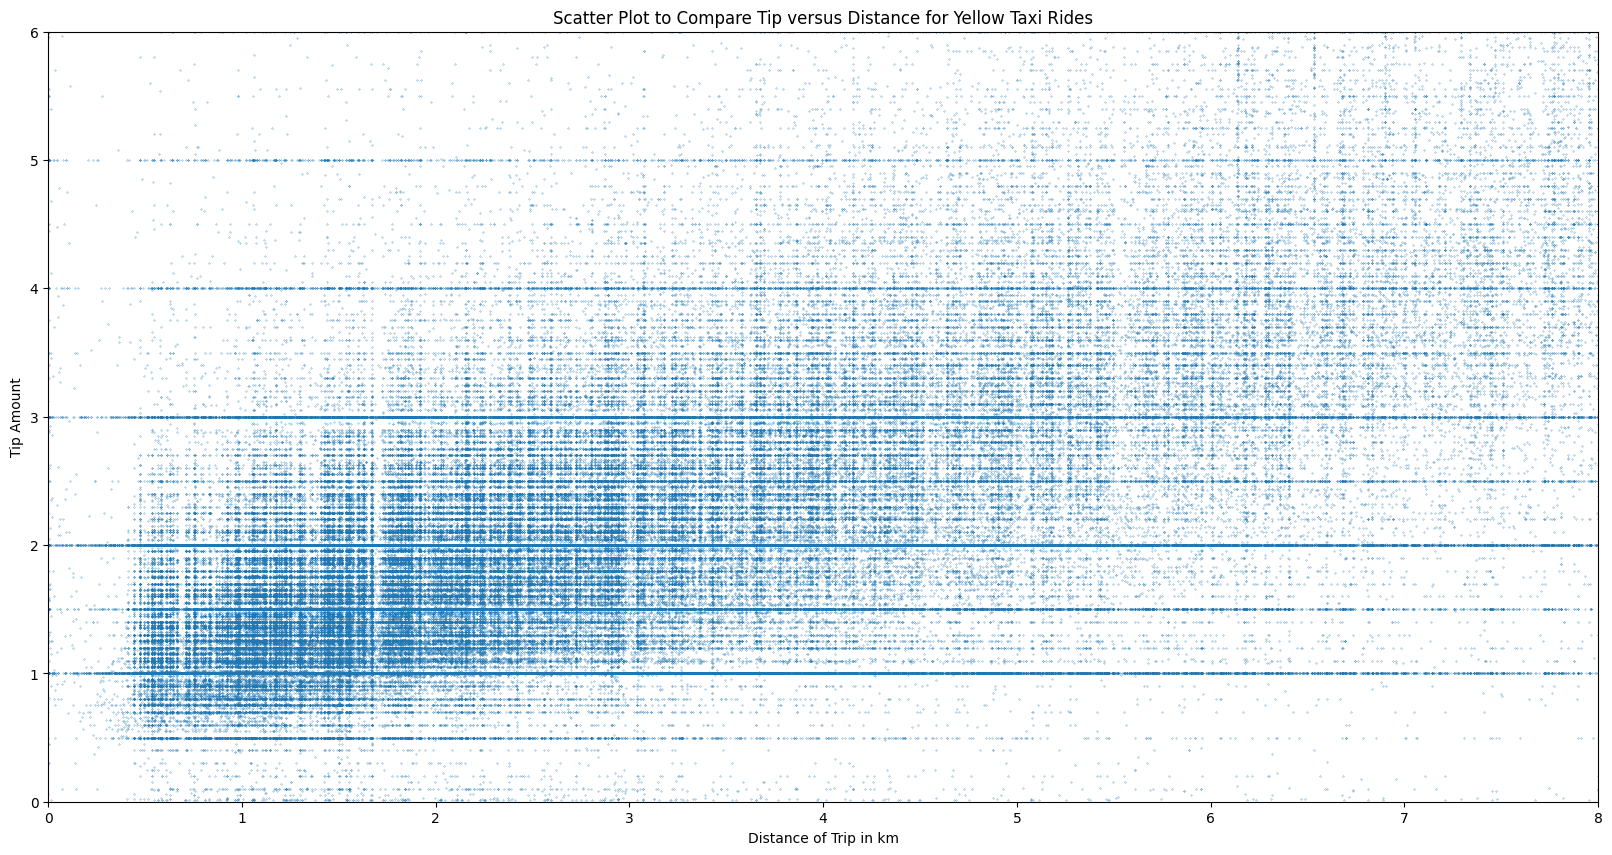

In [256]:
# "THIS IS WORKING"
dataframe_taxi_trips = get_data_for_visual_5()
plot_visual_5(dataframe_taxi_trips)

#### Visualization for Question 6

Create another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides. You may remove any outliers how you see fit.

In [ ]:
# use a more descriptive name for your function
def plot_visual_query_1(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    values = "..."  # use the dataframe to pull out values needed to plot
    
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    axes.plot(values, "...")
    # there are other methods to use to label your axes, to style 
    # and set up axes labels, etc
    axes.set_title("Some Descriptive Title")
    
    plt.show()

In [ ]:
df6_1 = pd.read_sql_table('taxi_trips', engine)
df6_1.head(1800)
#df6_1[df6_1['tpep_pickup_date']]

In [ ]:
#df6_1[(df6_1["tpep_pickup_date"]<'2015-07-01') & (df6_1["tpep_pickup_date"]>'2015-01-01')]

In [ ]:
df6_1.groupby(df6_1['tpep_pickup_date']).count()
df6_1['tpep_pickup_date'].unique()

In [ ]:
df6_2 = pd.read_sql_table('daily_weather', engine)
df6_2.info()

In [ ]:
df6_2_new = df6_2[["DailyPrecipitation", "ORDER_DATE", "ORDER_TIME"]]
df6_2_new
#df6_2_new_remove=df6_2_new[df6_2_new["DailyPrecipitation"]==None]
#df6_2_new_remove

In [ ]:
df6_2["DailyPrecipitation"].unique()

In [ ]:
a = df6_2_new[(df6_2_new["DailyPrecipitation"]!='T')]#or (df6_2_new["DailyPrecipitation"]!='None')]
a

In [ ]:
#df = df.replace(to_replace='None', value=np.nan).dropna()
b = a.replace(to_replace='None', value=np.nan).dropna()
b = b[(b["ORDER_DATE"]<'2015-07-01') & (b["ORDER_DATE"]>'2015-01-01')]
b

In [ ]:
b.info()

In [ ]:
b[(b["ORDER_DATE"]<'2015-07-01') & (b["ORDER_DATE"]>'2015-01-01')]

In [ ]:
######### "THIS WORKS"
df6_2 = pd.read_sql_table('daily_weather', engine)
df6_2_new = df6_2[["DailyPrecipitation", "ORDER_DATE", "ORDER_TIME"]]
a = df6_2_new[(df6_2_new["DailyPrecipitation"]!='T')]
b = a.replace(to_replace='None', value=np.nan).dropna()
#b = b[(b["ORDER_DATE"]<'2015-07-01') & (b["ORDER_DATE"]>'2015-01-01')]
b

In [ ]:
# use a more descriptive name for your function
def plot_visual_n(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    values = "..."  # use the dataframe to pull out values needed to plot
    
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    axes.plot(values, "...")
    # there are other methods to use to label your axes, to style 
    # and set up axes labels, etc
    axes.set_title("Some Descriptive Title")
    
    plt.show()

In [ ]:
def get_data_for_visual_n():
    # Query SQL database for the data needed.
    # You can put the data queried into a pandas dataframe, if you wish
    raise NotImplemented()

In [ ]:
some_dataframe = get_data_for_visual_n()
plot_visual_n(some_dataframe)

In [ ]:
some_dataframe = get_data_for_visual_n()
plot_visual_n(some_dataframe)